In [21]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, RepeatVector,GRU
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import ta
import json
#from preprocesslib import preprocessEach, makeY

In [24]:
base_path = '/content/drive/MyDrive/research/valueclassifier/'

In [25]:
'''
이런식으로 사용하면 됩니다.
from preprocesslib import preprocessEach, makeY
X = preprocessEach('overlap')
X bootstrap해서 -> X_final만든 후에
y = makeY('overlap', len(X_final))
'''

def preprocessEach(folder_name):
   # set file path
    folder_path = base_path + f'data/{folder_name}_clean'
    # folder_path = f'../data/{folder_name}_clean'


    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path, index_col=0)
        df.index = pd.to_datetime(df.index)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df['Diff'] = df['High'] - df['Low']
        df['RSI'] = ta.momentum.rsi(df['Close'])
        df['MACD'] = ta.trend.macd(df['Close'])


        df = df[['Close','Volume','Diff','open-close','MA5', 'Search','MACD','RSI']]
        df.fillna(0,inplace=True)



        #log transform
        df = np.log1p(df)
        # df.reset_index(inplace=True)
        df.fillna(0,inplace=True)

        scaler = MinMaxScaler()
        df = scaler.fit_transform(df[['Close','Volume','Diff','open-close','MA5', 'Search','MACD','RSI']])

        #insert list to array
        data_array.append(df)

    return np.array(data_array)

def makeYValue(folder_name, filelength):
    if folder_name=='growth':
        yValues = np.zeros(filelength)
    elif folder_name=='value':
        yValues = np.ones(filelength)

    y = np.column_stack([yValues.T])
    return y

def bootstrap(large, small):
    diff = len(large) - len(small)
    bootstrapped = small[np.random.choice(len(small), size=diff, replace=True)]
    return np.concatenate((small, bootstrapped), axis=0)

In [26]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs

In [27]:
xValues = np.concatenate((xValues, xOverlaps), axis=0)

In [28]:
xGrowths = bootstrap(xValues, xGrowths)

In [29]:
#make y values
yGrowths = makeYValue('growth', len(xGrowths))
yValues = makeYValue('value', len(xValues))

In [30]:
x = np.concatenate((xGrowths, xValues), axis=0)
y = np.concatenate((yGrowths, yValues), axis=0)

In [31]:
# #minmax scaling by element
# scaler = MinMaxScaler()
# for i in range(8):
#     x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [32]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    np.random.seed(2023)
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [33]:
X_train, X_test, Y_train, Y_test = splitData(x,y,0.8)

X_train = np.nan_to_num(X_train, nan=0)
X_test = np.nan_to_num(X_test, nan=0)

# Y_train = to_categorical(Y_train)
# Y_test = to_categorical(Y_test)

In [34]:
model_encoder=load_model(base_path + 'models/dimensionReduction.h5')
X_train_encoded = model_encoder.predict(X_train)
X_test_encoded = model_encoder.predict(X_test)

22/22 [==============================] - 1s 24ms/step


In [35]:
X_train_encoded.shape

(2804, 1248, 3)

In [36]:
count_0 = np.sum((Y_test == [0]).all(axis=1))
count_1 = np.sum((Y_test == [1]).all(axis=1))

print(f"[0]의 개수: {count_0}")
print(f"[1]의 개수: {count_1}")

[0]의 개수: 362
[1]의 개수: 340


In [37]:
def create_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(1248,3), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(16))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
mc = ModelCheckpoint('best_model_value.h5', monitor='val_acc', mode='max', save_best_only=True)

In [ ]:
final_model = create_model()
history=final_model.fit(X_train_encoded, Y_train, epochs=2000, validation_split=0.2, callbacks=[es, mc])

Epoch 1/2000
71/71 [==============================] - 12s 93ms/step - loss: 0.6936 - acc: 0.4953 - val_loss: 0.6926 - val_acc: 0.4848
Epoch 2/2000
71/71 [==============================] - 5s 76ms/step - loss: 0.6934 - acc: 0.5176 - val_loss: 0.6922 - val_acc: 0.4955
Epoch 3/2000
71/71 [==============================] - 5s 71ms/step - loss: 0.6918 - acc: 0.5221 - val_loss: 0.6922 - val_acc: 0.4920
Epoch 4/2000
71/71 [==============================] - 5s 73ms/step - loss: 0.6917 - acc: 0.5337 - val_loss: 0.6907 - val_acc: 0.5455
Epoch 5/2000
71/71 [==============================] - 5s 66ms/step - loss: 0.6908 - acc: 0.5207 - val_loss: 0.6920 - val_acc: 0.4991
Epoch 6/2000
71/71 [==============================] - 6s 86ms/step - loss: 0.6905 - acc: 0.5426 - val_loss: 0.6887 - val_acc: 0.5187
Epoch 7/2000
71/71 [==============================] - 4s 63ms/step - loss: 0.6902 - acc: 0.5310 - val_loss: 0.6882 - val_acc: 0.5294
Epoch 8/2000
71/71 [==============================] - 4s 62ms/step -

In [44]:
with open('history_value.json', 'w') as f:
    json.dump(history.history, f)

In [20]:
best_model_final=load_model('best_model_value.h5')

In [39]:
loss_f, accuracy_f = best_model_final.evaluate(X_test_encoded, Y_test)
y_pred_prob_f = best_model_final.predict(X_test_encoded)

22/22 [==============================] - 1s 25ms/step


In [40]:
def model_loss(history):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['loss'])
    plt.plot(epochs, history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [41]:
def model_acc(history):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['acc'])
    plt.plot(epochs, history['val_acc'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

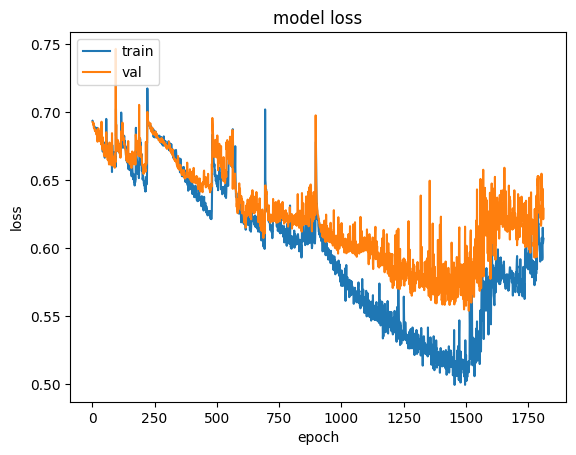

In [42]:
model_loss(history.history)

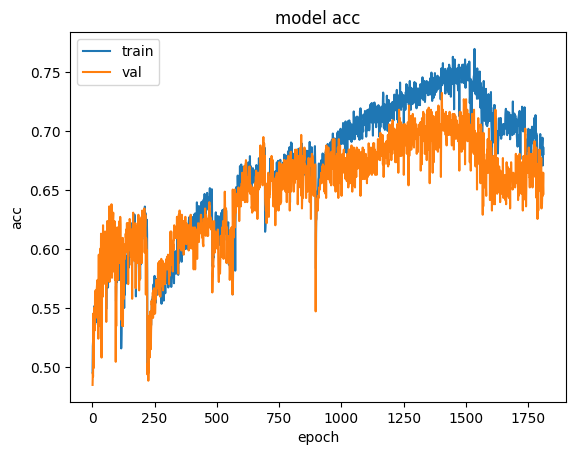

In [43]:
model_acc(history.history)